In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from utils import *

# Neural Networks
class SequenceModel(nn.Module):
    def __init__(self, representationSize, actionSize, recurrentStateSize):
        super().__init__()
        self.representationSize = representationSize
        self.actionSize = actionSize
        self.recurrentStateSize = recurrentStateSize
        self.recurrent = nn.GRUCell(representationSize + actionSize, recurrentStateSize)

    def forward(self, representation, action, recurrentState):
        return self.recurrent(torch.cat((representation, action), -1), recurrentState)
    
    def initializeRecurrentState(self):
        return torch.zeros(self.recurrentStateSize)

class PriorNet(nn.Module):
    def __init__(self, inputSize, representationClasses=16):
        super().__init__()
        self.representationSize = representationClasses
        self.mlp = sequentialModel1D(inputSize, [256, 256], representationClasses**2)
    
    def forward(self, x):
        logits = self.mlp(x)
        stateMatrix = logits.view(-1, self.representationSize, self.representationSize)
        _, indices = torch.max(stateMatrix, dim=-1)
        representation = F.one_hot(indices, num_classes=self.representationSize)
        return representation.view(-1), logits
    
class PosteriorNet(nn.Module):
    def __init__(self, inputSize, representationClasses=16):
        super().__init__()
        self.representationSize = representationClasses
        self.mlp = sequentialModel1D(inputSize, [256, 256], representationClasses**2)
    
    def forward(self, x):
        logits = self.mlp(x)
        stateMatrix = logits.view(-1, self.representationSize, self.representationSize)
        _, indices = torch.max(stateMatrix, dim=-1)
        representation = F.one_hot(indices, num_classes=self.representationSize)
        return representation.view(-1), logits

class ConvEncoder(nn.Module):
    def __init__(self, inputShape, outputSize):
        super(ConvEncoder, self).__init__()
        c, h, w = inputShape
        self.convolutionalNet = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, h/2, w/2)
            nn.Tanh(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, h/4, w/4)
            nn.Tanh(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, h/8, w/8)
            nn.Tanh(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, h/16, w/16)
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(256 * (h // 16) * (w // 16), outputSize),
            nn.Tanh(),
        )

    def forward(self, obs):
        return self.convolutionalNet(obs.float())

class ConvDecoder(nn.Module):
    def __init__(self, inputSize, outputShape):
        super(ConvDecoder, self).__init__()
        self.outputShape = outputShape
        c, h, w = outputShape
        self.fc = nn.Sequential(
            nn.Linear(inputSize, 256 * (h // 16) * (w // 16)),
            nn.Tanh(),
        )
        self.deconvolutionalNet = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, h/8, w/8)
            nn.Tanh(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, h/4, w/4)
            nn.Tanh(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, h/2, w/2)
            nn.Tanh(),
            nn.ConvTranspose2d(32, c, kernel_size=4, stride=2, padding=1),  # Output: (c, h, w)
            nn.Sigmoid(),  # Output pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.fc(x)
        batchSize = x.size(0)
        c, h, w = 256, self.outputShape[1] // 16, self.outputShape[2] // 16
        x = x.view(batchSize, c, h, w)
        return (self.deconvolutionalNet(x))


In [2]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from utils import *
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('episode_0_data.pkl', 'rb') as f:
    data = pickle.load(f)
observations = data['observations'].to(device).float()/255.0
actions = data['actions'].float().to(device)
episodeLength = len(actions)

representationClasses = 16
representationSize = representationClasses ** 2
actionSize = 3
recurrentStateSize = 256
compressedObservationsSize = 256
obsShape = (3, 96, 96)
numUpdates = 1000

convEncoder     = ConvEncoder(obsShape, compressedObservationsSize).to(device)
convDecoder     = ConvDecoder(representationSize + recurrentStateSize, obsShape).to(device)
sequenceModel   = SequenceModel(representationSize, actionSize, recurrentStateSize).to(device)
priorNet        = PriorNet(recurrentStateSize, representationClasses).to(device)
posteriorNet    = PosteriorNet(recurrentStateSize + compressedObservationsSize, representationClasses).to(device)

worldModelOptimizer = optim.AdamW(
    list(convEncoder.parameters()) + 
    list(convDecoder.parameters()) + 
    list(sequenceModel.parameters()) + 
    list(priorNet.parameters()) + 
    list(posteriorNet.parameters()), 
    lr=1e-3, 
    # weight_decay=1e-5
)

In [3]:
for i in range(1, numUpdates):
    encodedObservations = convEncoder(observations)
    recurrentState = sequenceModel.initializeRecurrentState().to(device)

    posteriorNetOutputs = []
    recurrentStates = [recurrentState]
    priorNetLogits = []
    posteriorNetLogits = []

    # There is a chance there is a bug here. I should have 256 reconstructedObs, for every obs
    for timestep in range(episodeLength):
        posteriorNetOutput, posteriorNetCurrentLogits = posteriorNet(torch.cat((recurrentStates[timestep], encodedObservations[timestep]), -1))
        posteriorNetOutputs.append(posteriorNetOutput)
        posteriorNetLogits.append(posteriorNetCurrentLogits)

        recurrentState = sequenceModel(posteriorNetOutputs[timestep].detach(), actions[timestep], recurrentStates[timestep])
        recurrentStates.append(recurrentState)

        _, priorNetCurrentLogits = priorNet(recurrentStates[timestep])
        priorNetLogits.append(priorNetCurrentLogits)

    posteriorNetOutputs = torch.stack(posteriorNetOutputs)      # [episodeLength    , representationSize]
    recurrentStates = torch.stack(recurrentStates)              # [episodeLength + 1, recurrentStateSize]
    priorNetLogits = torch.stack(priorNetLogits)                # [episodeLength    , representationSize]
    posteriorNetLogits = torch.stack(posteriorNetLogits)        # [episodeLength    , representationSize]
    fullStateRepresentations = torch.cat((recurrentStates[1:], posteriorNetOutputs), -1)

    reconstructedObservations = convDecoder(fullStateRepresentations)

    reconstructionLoss = F.mse_loss(reconstructedObservations, observations[1:], reduction="none").mean(dim=[-1, -2, -3]).mean() # why is it 255 and 256. In theory we should be able to reconstruct all 256
    priorNetLoss = F.mse_loss(priorNetLogits, posteriorNetLogits.detach())

    worldLoss = reconstructionLoss + priorNetLoss

    worldModelOptimizer.zero_grad()
    worldLoss.backward()
    worldModelOptimizer.step()

    if i % 10 == 0:
        print(f"Competed {i} training steps")


Competed 10 training steps
Competed 20 training steps
Competed 30 training steps
Competed 40 training steps
Competed 50 training steps
Competed 60 training steps
Competed 70 training steps
Competed 80 training steps
Competed 90 training steps
Competed 100 training steps
Competed 110 training steps
Competed 120 training steps
Competed 130 training steps
Competed 140 training steps
Competed 150 training steps
Competed 160 training steps
Competed 170 training steps
Competed 180 training steps
Competed 190 training steps
Competed 200 training steps
Competed 210 training steps
Competed 220 training steps
Competed 230 training steps
Competed 240 training steps
Competed 250 training steps
Competed 260 training steps
Competed 270 training steps
Competed 280 training steps
Competed 290 training steps
Competed 300 training steps
Competed 310 training steps
Competed 320 training steps
Competed 330 training steps
Competed 340 training steps
Competed 350 training steps
Competed 360 training steps
C

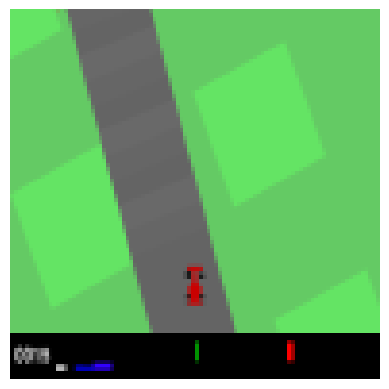

In [23]:
displayImage(np.transpose((observations).cpu()[51], (1, 2, 0)))

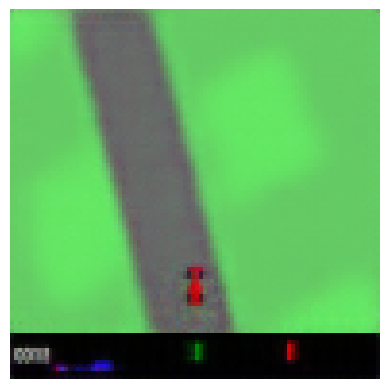

In [24]:
displayImage(np.transpose(reconstructedObservations.detach().cpu().numpy()[50], (1, 2, 0)))

In [6]:
reconstructedObservations

tensor([[[[0.2714, 0.1308, 0.1124,  ..., 0.0822, 0.0811, 0.1553],
          [0.0967, 0.0278, 0.0185,  ..., 0.0103, 0.0115, 0.0592],
          [0.0764, 0.0266, 0.0140,  ..., 0.0102, 0.0108, 0.0429],
          ...,
          [0.0764, 0.0128, 0.0238,  ..., 0.0085, 0.0094, 0.0439],
          [0.0443, 0.0143, 0.0188,  ..., 0.0057, 0.0076, 0.0395],
          [0.0844, 0.0180, 0.0241,  ..., 0.0132, 0.0262, 0.0785]],

         [[0.1439, 0.0656, 0.0538,  ..., 0.0488, 0.0539, 0.1101],
          [0.0379, 0.0254, 0.0131,  ..., 0.0117, 0.0133, 0.0389],
          [0.0435, 0.0292, 0.0165,  ..., 0.0138, 0.0140, 0.0396],
          ...,
          [0.0238, 0.0116, 0.0053,  ..., 0.0100, 0.0045, 0.0242],
          [0.0305, 0.0119, 0.0061,  ..., 0.0069, 0.0057, 0.0283],
          [0.0912, 0.0206, 0.0199,  ..., 0.0173, 0.0178, 0.0734]],

         [[0.2856, 0.1311, 0.1491,  ..., 0.0741, 0.0937, 0.2359],
          [0.1298, 0.0380, 0.0387,  ..., 0.0162, 0.0291, 0.0806],
          [0.0839, 0.0273, 0.0129,  ..., 0